Учасник проекта: Христофорова Полина Андреевна

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augumentation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tkinter as tk
from tkinter import filedialog #provides a dialog box to select files.
from PIL import Image, ImageTk #ImageTk - Converts images for display in Tkinter GUIs
import numpy as np

Загрузим датасет с Кагла. Характеристики датасета:

> This dataset contains satellite images (350x350px) in 2 classes:
> 
> * Wildfire : 22710 images
> * No wildfire : 20140 images
> 
> The data was divided into train, test and validation with these percentages :
> 
> * Train : ~70%
> * Test : ~15%
> * Validation : ~15%

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")

print("Path to dataset files:", path)


100%|██████████| 1.45G/1.45G [00:17<00:00, 89.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1


Установим основные переменные.

- В числе прочего, поменяем размер изображения на 416. Изменение размера может помочь улучшить производительность модели, а так же позволит провести более качественный сравнительный анализ текущей модели классификации с другими моделями проекта

- Метрика ROC_AUC также была выбрана неслучайно. Она позваляет оценить, как хорошо модель разделяет классы в целом

In [6]:
# Path to data
MAIN_DIR = path
# Evaluation metric
METRIC = 'AUC'
# Count of epochs
C_EPOCHS = 10
# Pictures size
SIZE = 416

In [5]:
train_dir = MAIN_DIR+"/train"
valid_dir = MAIN_DIR+"/valid"
test_dir = MAIN_DIR+"/test"

# Pipline

In [7]:
# Set up ImageDataGenerators for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(SIZE, SIZE), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(SIZE, SIZE), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(SIZE, SIZE), batch_size=32, class_mode='binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


*Строим модель со слоями:*
1. Первый сверточный слой на 32 фильтра
1. Первый слой подвыборки: максимальное значение для блока 2х2 пикселя
1. Второй сверточный слой на 64 фильтра
1. Второй слой подвыборки: снова уменьшаем размерность
1. Преобразуем в одномерный вектор для передачи в полносвязные слои
1. Полносвязный слой на 128 нейрона
1. Слой регурялизации: отключает 50% нейронов для уменьшения зависимостей между ними и переобучений
1. Выходной полносвязный слой на один нейрон (бинарная классификация)


- В качестве функции активации слоев берем ReLu
- В качестве функции активации выходного слоя берем sigmoid - приведение результата в диапазон 0-1


*Компилируем модель:*
- Используем оптимизатор Adam с адаптивной регулировкой скорости обучения для каждого параметра
- Используем бинарную кросс-энтропию в качестве функции потерь исходя из класса задачи
- На ROC_AUC метрике

In [11]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: wildfire or no wildfire
])

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f'{METRIC}'])

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
%%time

history = model_1.fit(train_generator, validation_data=valid_generator, epochs=C_EPOCHS, verbose=1)

Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 244s 245ms/step - AUC: 0.9307 - loss: 0.8741 - val_AUC: 0.9871 - val_loss: 0.1424
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 215s 228ms/step - AUC: 0.9793 - loss: 0.1779 - val_AUC: 0.9906 - val_loss: 0.1217
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 214s 226ms/step - AUC: 0.9886 - loss: 0.1305 - val_AUC: 0.9910 - val_loss: 0.1239
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 226s 239ms/step - AUC: 0.9934 - loss: 0.0972 - val_AUC: 0.9898 - val_loss: 0.1335
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 215s 227ms/step - AUC: 0.9971 - loss: 0.0627 - val_AUC: 0.9896 - val_loss: 0.1285
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 218s 231ms/step - AUC: 0.9984 - loss: 0.0429 - val_AUC: 0.9856 - val_loss: 0.1632
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 217s 229ms/step - AUC: 0.9990 - loss: 0.0322 - val_AUC: 0.9791 - val_loss: 0.2560
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 219s 231ms/step - AUC: 0.9987 - loss: 0.0363 - val_AUC: 0.9819 - val_loss: 0.2166
Epoch 9/10
946/946 ━━━━━

In [14]:
history.history

{'AUC': [0.9626063108444214,
  0.9804283976554871,
  0.9873760938644409,
  0.993665337562561,
  0.9970666766166687,
  0.9982283115386963,
  0.999361515045166,
  0.9992532134056091,
  0.9994603991508484,
  0.99957674741745],
 'loss': [0.3306191861629486,
  0.1745905727148056,
  0.13718664646148682,
  0.09599392116069794,
  0.06288918852806091,
  0.04669911414384842,
  0.0290161594748497,
  0.028205232694745064,
  0.021293338388204575,
  0.016986848786473274],
 'val_AUC': [0.9871130585670471,
  0.9905650019645691,
  0.9910134673118591,
  0.989798903465271,
  0.9895970225334167,
  0.9855815172195435,
  0.9791387319564819,
  0.9819383025169373,
  0.9817000031471252,
  0.9822196364402771],
 'val_loss': [0.14238299429416656,
  0.12166735529899597,
  0.12390952557325363,
  0.13349317014217377,
  0.12847544252872467,
  0.16319799423217773,
  0.2560311555862427,
  0.21656176447868347,
  0.240664541721344,
  0.20721648633480072]}

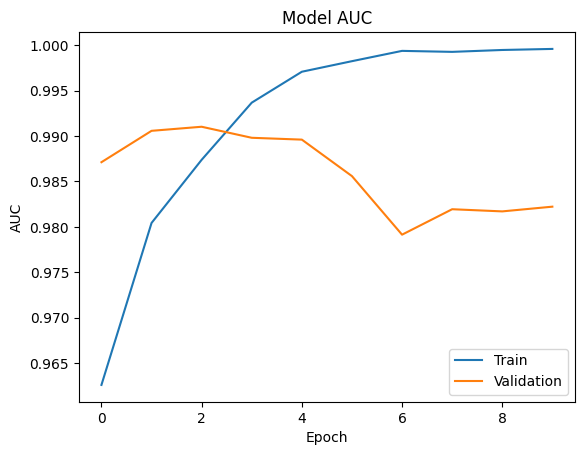

In [15]:
plt.plot(history.history[f'{METRIC}'])
plt.plot(history.history[f'val_{METRIC}'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

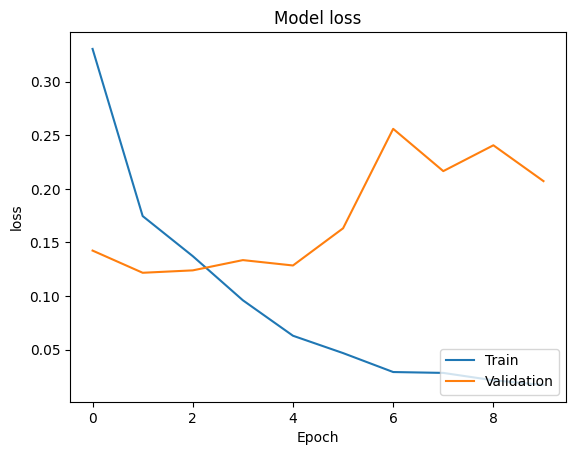

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

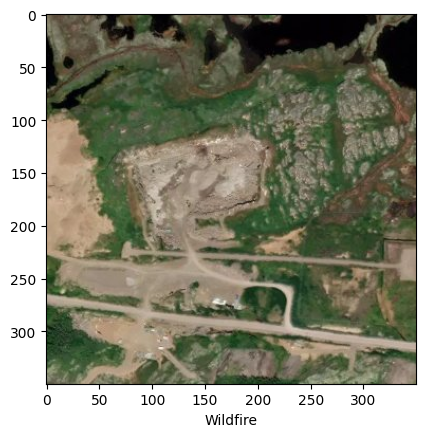

In [17]:
import matplotlib.image as mping

test_img_path = MAIN_DIR+"/test/wildfire/-60.6867,50.26079.jpg"

img = mping.imread(test_img_path)
imgplot = plt.imshow(img)
plt.xlabel("Wildfire")
plt.show()

In [18]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(SIZE,SIZE))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,SIZE,SIZE,3)
test_arr.append(test_image)

In [19]:
model_1.predict(test_arr)[0][0]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_9
Received: inputs=('Tensor(shape=(1, 416, 416, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


0.50433034

In [20]:
result = model_1.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step - AUC: 0.9880 - loss: 0.1543


Считвем финальную метрику на тестовом датасете

In [21]:
print(f'Loss value: {result[0]}\nROC_AUC: {result[1]}')

Loss value: 0.15171954035758972
ROC_AUC: 0.9887334108352661


Таким образом удалось построить 8ми слойную модель бинарной классификации по определению наличия следов лесного пожара спутниковых снимках со сходимостью на двух эпохаха и точностью 0.9887 ROC_AUC 